### Creating Model 3

* Creating a 3rd model for the NFL Play data. The goal is to predict the play type on 4th down.
* Logistic Regression & Random Forest have been completed, so the next step is a Naive Bayes model, adjusting the smoothing parameters as well as whether the data are sampled relative to their regular distribution or by over and undersampling accordingly.

In [1]:
from pyspark.ml import Pipeline  
from pyspark.ml.feature import *  
from pyspark.ml.classification import LogisticRegression
import nfl_data_py as nfl
import numpy as np
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTENC
import pandas as pd
from imblearn.combine import SMOTEENN
from DataPipelineFxn import *
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import TrainValidationSplit, ParamGridBuilder
import seaborn as sns
import matplotlib.pyplot as plt
from pyspark.sql import functions as F

In [2]:
# get the spark session and data frame
data = GetSparkDF(include_undersample = True)

2000 done.
2001 done.
2002 done.
2003 done.
2004 done.
2005 done.
2006 done.
2007 done.
2008 done.
2009 done.
2010 done.
2011 done.
2012 done.
2013 done.
2014 done.
2015 done.
2016 done.
2017 done.
2018 done.
2019 done.
2020 done.
2021 done.
2022 done.
2023 done.


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/12/02 20:00:46 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
24/12/02 20:00:47 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
24/12/02 20:01:01 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.
24/12/02 20:01:02 WARN TaskSetManager: Stage 0 contains a task of very large size (9437 KiB). The maximum recommended task size is 1000 KiB.
24/12/02 20:01:10 WARN TaskSetManager: Stage 3 contains a task of very large size (9437 KiB). The maximum recommended task size is 1000 KiB.
24/12/02 20:01:15 WARN TaskSetManager: Stage 4 contains a task of very large size (3174 KiB). The maximum recommended task size is 1000 KiB.
24/12/02 20:01:18 WARN Ta

In [3]:
spark, df, test_df, undersample_df = data

### Create the Model Pipeline

In [4]:
from pyspark.ml.classification import NaiveBayes

In [5]:
str_col = ["home_team", "away_team", "season_type", "posteam", "posteam_type", "defteam", "side_of_field", "game_half",
        "play_type", "season", 'roof', 'surface']
str_col_output = ["home_team_idx", "away_team_idx", "season_type_idx", "posteam_idx", "posteam_type_idx", "defteam_idx",
                  "side_of_field_idx", "game_half_idx", "play_type_idx", "season_idx", 'roof_idx', 'surface_idx']
ohe_col_input = ["home_team_idx", "away_team_idx", "season_type_idx", "posteam_idx", "posteam_type_idx", "defteam_idx",
                  "side_of_field_idx", "game_half_idx", "season_idx", 'roof_idx', 'surface_idx']
ohe_col_vec = ["home_team_vec", "away_team_vec", "season_type_vec", "posteam_vec", "posteam_type_vec", "defteam_vec",
                  "side_of_field_vec", "game_half_ivec", "season_vec", 'roof_vec', 'surface_vec']


# process using string indexer first for catgeorical features  
stringIndexer = StringIndexer(inputCols=str_col, outputCols=str_col_output)

# process rating data into second feature
ohe = OneHotEncoder(inputCols=ohe_col_input, outputCols=ohe_col_vec) 

# Assemble features column
va = VectorAssembler(inputCols=ohe_col_vec, outputCol="features") 

# process data using maxabs scaler, not necessarily important for trees but consistency
scaler = MaxAbsScaler(inputCol="features", outputCol="scaledFeatures")

# define the model
nb = NaiveBayes(
    featuresCol = 'features', labelCol = 'play_type_idx'
)

# Fit the pipeline
pipeline = Pipeline(stages=[stringIndexer, ohe, va, scaler, nb])

In [6]:
# hyperparameter search across max depth, bins, and iterations
# paramGrid = ParamGridBuilder()\
#     .addGrid(gbt.maxDepth, np.arange(10, 100, step = 10)) \
#     .addGrid(gbt.maxIter, [20, 50, 100, 200])\
#     .addGrid(gbt.maxBins, np.arange(10, 100, step = 10))\
#     .build()

paramGrid = ParamGridBuilder()\
    .addGrid(nb.smoothing, np.arange(0.05, 1, step = 0.05)) \
    .build()

# build the evaluator
evaluator = MulticlassClassificationEvaluator(
    predictionCol="prediction",
    labelCol="play_type_idx",
    metricName="accuracy"
)

# set up the train validation split
tvs = TrainValidationSplit(
    estimator=pipeline,
    evaluator=evaluator,
    estimatorParamMaps=paramGrid,
    # 80% of the data will be used for training, 20% for validation.
    trainRatio=0.8
)

In [7]:
df.select(df.roof).distinct().show()

24/12/02 20:01:27 WARN TaskSetManager: Stage 6 contains a task of very large size (9437 KiB). The maximum recommended task size is 1000 KiB.


+--------+
|    roof|
+--------+
|outdoors|
|  closed|
|    open|
|    dome|
+--------+



In [28]:
# need to replace the empty string in surface
df = df.withColumn(
    'surface',
    F.when(df.surface == '', 'Undefined').otherwise(df.surface)
)

undersample_df = undersample_df.withColumn(
    'surface',
    F.when(undersample_df.surface == '', 'Undefined').otherwise(undersample_df.surface)
)

# fit the model with the hyperparameter search
nb_model = tvs.fit(df)

# fit to undersample as well
nb_undersample_model = tvs.fit(undersample_df)

24/12/02 20:10:52 WARN TaskSetManager: Stage 1122 contains a task of very large size (9437 KiB). The maximum recommended task size is 1000 KiB.
24/12/02 20:10:53 WARN TaskSetManager: Stage 1125 contains a task of very large size (9437 KiB). The maximum recommended task size is 1000 KiB.
24/12/02 20:10:54 WARN TaskSetManager: Stage 1128 contains a task of very large size (9437 KiB). The maximum recommended task size is 1000 KiB.
24/12/02 20:10:54 WARN TaskSetManager: Stage 1131 contains a task of very large size (9437 KiB). The maximum recommended task size is 1000 KiB.
24/12/02 20:10:55 WARN TaskSetManager: Stage 1133 contains a task of very large size (9437 KiB). The maximum recommended task size is 1000 KiB.
24/12/02 20:10:56 WARN TaskSetManager: Stage 1136 contains a task of very large size (9437 KiB). The maximum recommended task size is 1000 KiB.
24/12/02 20:10:56 WARN TaskSetManager: Stage 1139 contains a task of very large size (9437 KiB). The maximum recommended task size is 10

### Evaluate the Models

#### Non-Undersample

In [29]:
best_model = nb_model.bestModel

# Extract the parameter map of the best model
best_params = best_model.stages[-1].extractParamMap()

# Print the parameters values
print("Tuned Parameters of the Best Model:")
for param, value in best_params.items():
    print(f"{param.name}: {value}")

Tuned Parameters of the Best Model:
featuresCol: features
labelCol: play_type_idx
modelType: multinomial
predictionCol: prediction
probabilityCol: probability
rawPredictionCol: rawPrediction
smoothing: 0.1


In [30]:
# have to change test df instance
test_df = test_df.withColumn(
    'surface',
    F.when(test_df.surface == '', 'Undefined').otherwise(test_df.surface)
)

prediction = best_model.transform(test_df)

In [31]:
f1_evaluator = MulticlassClassificationEvaluator(
    labelCol='play_type_idx', predictionCol="prediction",
    metricName='f1'
)

accuracy_evaluator = MulticlassClassificationEvaluator(
    labelCol='play_type_idx', predictionCol="prediction",
    metricName='accuracy'
)

precision_by_label_eval = MulticlassClassificationEvaluator(
    labelCol='play_type_idx', predictionCol="prediction",
    metricName='precisionByLabel'
)

weighted_precision_eval = MulticlassClassificationEvaluator(
    labelCol='play_type_idx', predictionCol="prediction",
    metricName='weightedPrecision'
)


weighted_recall_eval = MulticlassClassificationEvaluator(
    labelCol='play_type_idx', predictionCol="prediction",
    metricName='weightedRecall'
)

f1_score = f1_evaluator.evaluate(prediction)
accuracy = accuracy_evaluator.evaluate(prediction)
precision_by_label = precision_by_label_eval.evaluate(prediction)
precision = weighted_precision_eval.evaluate(prediction)
recall = weighted_recall_eval.evaluate(prediction)

24/12/02 20:11:58 WARN TaskSetManager: Stage 1558 contains a task of very large size (9437 KiB). The maximum recommended task size is 1000 KiB.
24/12/02 20:11:59 WARN TaskSetManager: Stage 1559 contains a task of very large size (9437 KiB). The maximum recommended task size is 1000 KiB.
24/12/02 20:12:02 WARN TaskSetManager: Stage 1568 contains a task of very large size (9437 KiB). The maximum recommended task size is 1000 KiB.
24/12/02 20:12:02 WARN TaskSetManager: Stage 1569 contains a task of very large size (9437 KiB). The maximum recommended task size is 1000 KiB.
24/12/02 20:12:04 WARN TaskSetManager: Stage 1578 contains a task of very large size (9437 KiB). The maximum recommended task size is 1000 KiB.
24/12/02 20:12:05 WARN TaskSetManager: Stage 1579 contains a task of very large size (9437 KiB). The maximum recommended task size is 1000 KiB.
24/12/02 20:12:07 WARN TaskSetManager: Stage 1588 contains a task of very large size (9437 KiB). The maximum recommended task size is 10

In [32]:
prediction.groupby(prediction.prediction).count().show()

24/12/02 20:12:33 WARN TaskSetManager: Stage 1608 contains a task of very large size (9437 KiB). The maximum recommended task size is 1000 KiB.
24/12/02 20:12:33 WARN TaskSetManager: Stage 1609 contains a task of very large size (9437 KiB). The maximum recommended task size is 1000 KiB.


+----------+-----+
|prediction|count|
+----------+-----+
|       0.0|62708|
|       1.0| 1362|
|       3.0|    1|
|       2.0|  538|
+----------+-----+



In [33]:
prediction.groupby(prediction.play_type_idx).count().show()

24/12/02 20:12:38 WARN TaskSetManager: Stage 1622 contains a task of very large size (9437 KiB). The maximum recommended task size is 1000 KiB.
24/12/02 20:12:38 WARN TaskSetManager: Stage 1623 contains a task of very large size (9437 KiB). The maximum recommended task size is 1000 KiB.


+-------------+-----+
|play_type_idx|count|
+-------------+-----+
|          0.0|41679|
|          1.0|12679|
|          4.0| 2760|
|          3.0| 2813|
|          2.0| 4678|
+-------------+-----+



In [34]:
labels = prediction.select([prediction.play_type, prediction.play_type_idx]).distinct().orderBy(prediction.play_type_idx).select(prediction.play_type).collect()
labels = [x[0] for x in labels]

24/12/02 20:12:41 WARN TaskSetManager: Stage 1636 contains a task of very large size (9437 KiB). The maximum recommended task size is 1000 KiB.
24/12/02 20:12:42 WARN TaskSetManager: Stage 1637 contains a task of very large size (9437 KiB). The maximum recommended task size is 1000 KiB.


In [35]:
results = f'''
F1: {f1_score}
Accuracy: {accuracy}
Precision by Label: {precision_by_label}
Weighted Precision: {precision}
Weighted Recall: {recall}
'''

print(results)


F1: 0.5157640802196016
Accuracy: 0.6369391261279388
Precision by Label: 0.648928366396632
Weighted Precision: 0.4837862010943764
Weighted Recall: 0.6369391261279389



In [36]:
from pyspark.sql.types import FloatType
from pyspark.mllib.evaluation import MulticlassMetrics

#Adapting code from https://www.kaggle.com/code/ashokkumarpalivela/multiclass-classification-using-pyspark for confusion matrix
preds_and_labels = prediction.select(['prediction','play_type_idx'])\
                              .withColumn('play_type_idx', col('play_type_idx')\
                              .cast(FloatType()))\
                              .orderBy('prediction')
    
metrics = MulticlassMetrics(preds_and_labels.rdd.map(tuple))

print(metrics.confusionMatrix().toArray())

24/12/02 20:12:48 WARN TaskSetManager: Stage 1661 contains a task of very large size (9437 KiB). The maximum recommended task size is 1000 KiB.
24/12/02 20:12:48 WARN TaskSetManager: Stage 1662 contains a task of very large size (9437 KiB). The maximum recommended task size is 1000 KiB.
/sfs/gpfs/tardis/home/ean8fr/distributed-computing-final/env/lib/python3.11/site-packages/pyspark/sql/context.py:157: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


[[4.0693e+04 7.3500e+02 2.5100e+02 0.0000e+00 0.0000e+00]
 [1.2210e+04 3.5700e+02 1.1100e+02 1.0000e+00 0.0000e+00]
 [4.4500e+03 1.2600e+02 1.0200e+02 0.0000e+00 0.0000e+00]
 [2.7000e+03 7.1000e+01 4.2000e+01 0.0000e+00 0.0000e+00]
 [2.6550e+03 7.3000e+01 3.2000e+01 0.0000e+00 0.0000e+00]]


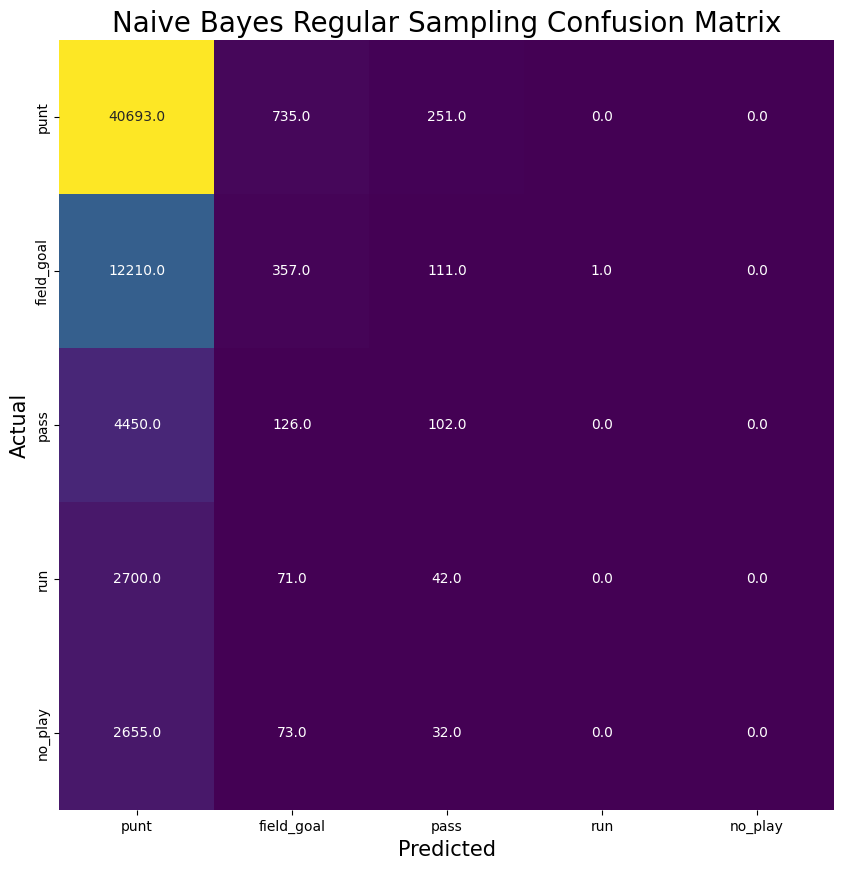

In [38]:
# labels = ["field_goal", "no_play", "pass", "punt", "run"]
_ = plt.figure(figsize=(10, 10))
ax = sns.heatmap(metrics.confusionMatrix().toArray(),
            cmap='viridis',
            annot=True,fmt='0',
            cbar=False, 
            xticklabels=labels,
            yticklabels=labels)

plt.title('Naive Bayes Regular Sampling Confusion Matrix', fontsize = 20) # title with fontsize 20
plt.xlabel('Predicted', fontsize = 15) # x-axis label with fontsize 15
plt.ylabel('Actual', fontsize = 15) # y-axis label with fontsize 15
plt.savefig('figures/naive-bayes-normal-confusion-matrix.png')

#### Undersample

Tuned Parameters of the Best Model:
featuresCol: features
labelCol: play_type_idx
modelType: multinomial
predictionCol: prediction
probabilityCol: probability
rawPredictionCol: rawPrediction
smoothing: 0.05


24/12/02 20:14:12 WARN TaskSetManager: Stage 1685 contains a task of very large size (9437 KiB). The maximum recommended task size is 1000 KiB.
24/12/02 20:14:12 WARN TaskSetManager: Stage 1686 contains a task of very large size (9437 KiB). The maximum recommended task size is 1000 KiB.
24/12/02 20:14:15 WARN TaskSetManager: Stage 1695 contains a task of very large size (9437 KiB). The maximum recommended task size is 1000 KiB.
24/12/02 20:14:15 WARN TaskSetManager: Stage 1696 contains a task of very large size (9437 KiB). The maximum recommended task size is 1000 KiB.
24/12/02 20:14:17 WARN TaskSetManager: Stage 1705 contains a task of very large size (9437 KiB). The maximum recommended task size is 1000 KiB.
24/12/02 20:14:18 WARN TaskSetManager: Stage 1706 contains a task of very large size (9437 KiB). The maximum recommended task size is 1000 KiB.
24/12/02 20:14:20 WARN TaskSetManager: Stage 1715 contains a task of very large size (9437 KiB). The maximum recommended task size is 10


F1: 0.3047152241286471
Accuracy: 0.2546549242365615
Precision by Label: 0.21598509863686394
Weighted Precision: 0.5071762822502063
Weighted Recall: 0.25465492423656144



24/12/02 20:14:26 WARN TaskSetManager: Stage 1736 contains a task of very large size (9437 KiB). The maximum recommended task size is 1000 KiB.
24/12/02 20:14:28 WARN TaskSetManager: Stage 1760 contains a task of very large size (9437 KiB). The maximum recommended task size is 1000 KiB.
24/12/02 20:14:29 WARN TaskSetManager: Stage 1761 contains a task of very large size (9437 KiB). The maximum recommended task size is 1000 KiB.
/sfs/gpfs/tardis/home/ean8fr/distributed-computing-final/env/lib/python3.11/site-packages/pyspark/sql/context.py:157: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


[[ 2551.  2117.  3228.  2940.  1843.]
 [  437.   559.   858.   544.   362.]
 [  480.   747.  2153.   584.   714.]
 [ 7878.  7304. 10119. 10728.  5650.]
 [  465.   487.   863.   536.   462.]]


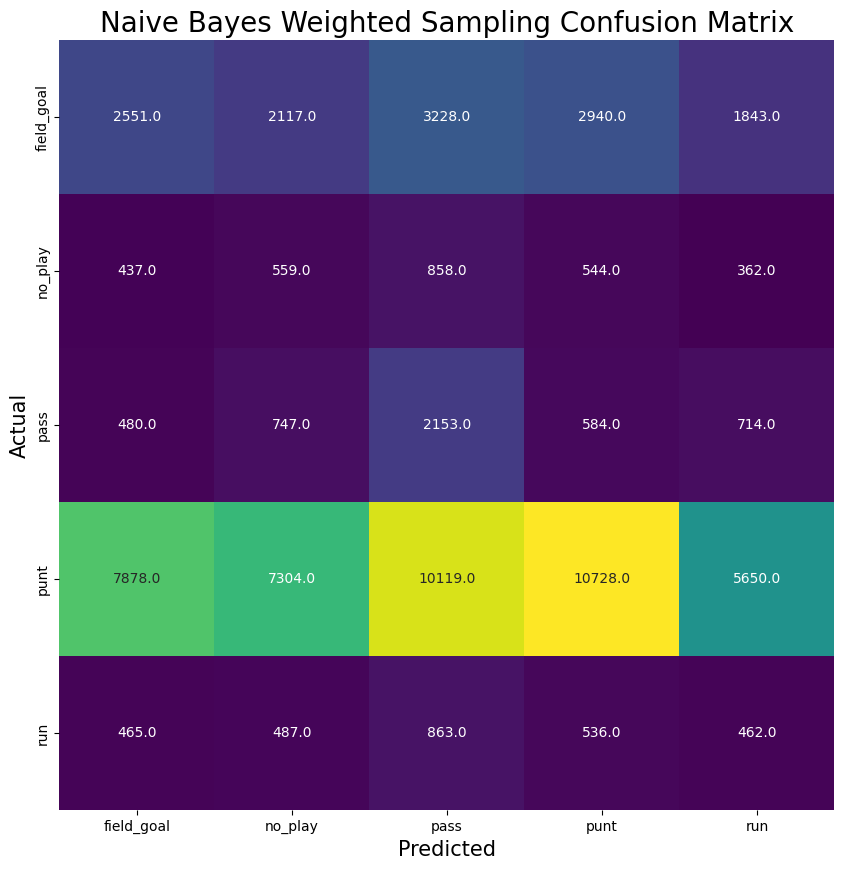

In [39]:
best_model = nb_undersample_model.bestModel

# Extract the parameter map of the best model
best_params = best_model.stages[-1].extractParamMap()

# Print the parameters values
print("Tuned Parameters of the Best Model:")
for param, value in best_params.items():
    print(f"{param.name}: {value}")

# get prediction
prediction = best_model.transform(test_df)

# use same evaluators
f1_score = f1_evaluator.evaluate(prediction)
accuracy = accuracy_evaluator.evaluate(prediction)
precision_by_label = precision_by_label_eval.evaluate(prediction)
precision = weighted_precision_eval.evaluate(prediction)
recall = weighted_recall_eval.evaluate(prediction)

results = f'''
F1: {f1_score}
Accuracy: {accuracy}
Precision by Label: {precision_by_label}
Weighted Precision: {precision}
Weighted Recall: {recall}
'''
print(results)

labels = prediction.select([prediction.play_type, prediction.play_type_idx]).distinct().orderBy(prediction.play_type_idx).select(prediction.play_type).collect()
labels = [x[0] for x in labels]

preds_and_labels = prediction.select(['prediction','play_type_idx'])\
                              .withColumn('play_type_idx', col('play_type_idx')\
                              .cast(FloatType()))\
                              .orderBy('prediction')
    
metrics = MulticlassMetrics(preds_and_labels.rdd.map(tuple))

print(metrics.confusionMatrix().toArray())

_ = plt.figure(figsize=(10, 10))
ax = sns.heatmap(metrics.confusionMatrix().toArray(),
            cmap='viridis',
            annot=True,fmt='0',
            cbar=False, 
            xticklabels=labels,
            yticklabels=labels)

plt.title('Naive Bayes Weighted Sampling Confusion Matrix', fontsize = 20) # title with fontsize 20
plt.xlabel('Predicted', fontsize = 15) # x-axis label with fontsize 15
plt.ylabel('Actual', fontsize = 15) # y-axis label with fontsize 15
plt.savefig('figures/naive-bayes-undersample-confusion-matrix.png')

### Conclusions

Listed are some general observations
* We achieve a much better performance across all metrics when we sample from the regular distribution rather than applying undersampling and oversampling. The accuracy normally is ~65% compared to ~25% when changing the sampling method. One downside is that the model predicts "punt" much more frequently than any other classes when regular sampling is used. Though this follows the general distribtuion of the training data, it does not account for the other classes well.
* When comapred to the other tested models, the Naive Bayes does neither substantially better or worse. It is in line with the Logistic Regression and Random Forest methods used. 